In [1]:
# This notebook is derived from Qiskit and includes modifications by qBraid.
#
# (C) Copyright IBM 2020.
# (C) Copyright qBraid 2023.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.

# qBraid-SDK Qiskit on AWS Device Demo: Bernstein-Vazirani Algorithm

Per usual, install the qBraid SDK environment on Lab, and use the qBraid CLI to enable [Quantum Jobs](https://docs.qbraid.com/en/latest/lab/quantumjobs.html):

In [2]:
!qbraid jobs enable qbraid_sdk

Successfully enabled qBraid Quantum Jobs in the qbraid_sdk environment.
Every AWS job you run will now be submitted through the qBraid API, so no access keys/tokens are necessary. 

To disable, run: `qbraid jobs disable qbraid_sdk`


You can check that the `jobs` keyword next to the qBraid SDK environment is now green.

In [3]:
!qbraid envs list

# installed environments:
#
default                  jobs  /opt/.qbraid/environments/qbraid_000000
aws_braket               jobs  /home/jovyan/.qbraid/environments/aws_braket_kwx6dl
qiskit                   jobs  /home/jovyan/.qbraid/environments/qiskit_i5o7if
qiskit_gpu                     /home/jovyan/.qbraid/environments/qiskit_gpu_tyt64d
tensorflow                     /home/jovyan/.qbraid/environments/tensorflow_uorhf3
qbraid_sdk               jobs  /home/jovyan/.qbraid/environments/qbraid_sdk_9j9sjy
pyquil                         /home/jovyan/.qbraid/environments/pyquil_i4l3hx
mitiq                          /home/jovyan/.qbraid/environments/mitiq_7rq6q3



It's important to import the qBraid SDK only *after* you have enabled quantum jobs.

In [4]:
import qbraid

qbraid.__version__

'0.4.5'

## Creating the Circuit

In [5]:
from qiskit import QuantumCircuit

The code for this circuit was taken from IBMs Bernstein-Vazirani algorithm tutorial. Check out their [tutorial](https://www.youtube.com/watch?v=sqJIpHYl7oo) for a more in depth explanation. Classically, it takes n queries to decipher a secret string of length n – the Bernstein-Vazirani algorithm allows us to develop an oracle in a quantum circuit that is able to guess the string with just one query!

In [6]:
s = "110101"  # the number we hope to guess
n = len(s)

qiskit_circuit = QuantumCircuit(n + 1, n)

qiskit_circuit.x(n)
qiskit_circuit.barrier()
qiskit_circuit.h(range(n + 1))
qiskit_circuit.barrier()

for ii, yesno in enumerate(reversed(s)):
    if yesno == "1":
        qiskit_circuit.cx(ii, n)

qiskit_circuit.barrier()
qiskit_circuit.h(range(n + 1))
qiskit_circuit.barrier()
qiskit_circuit.measure(range(n), range(n))

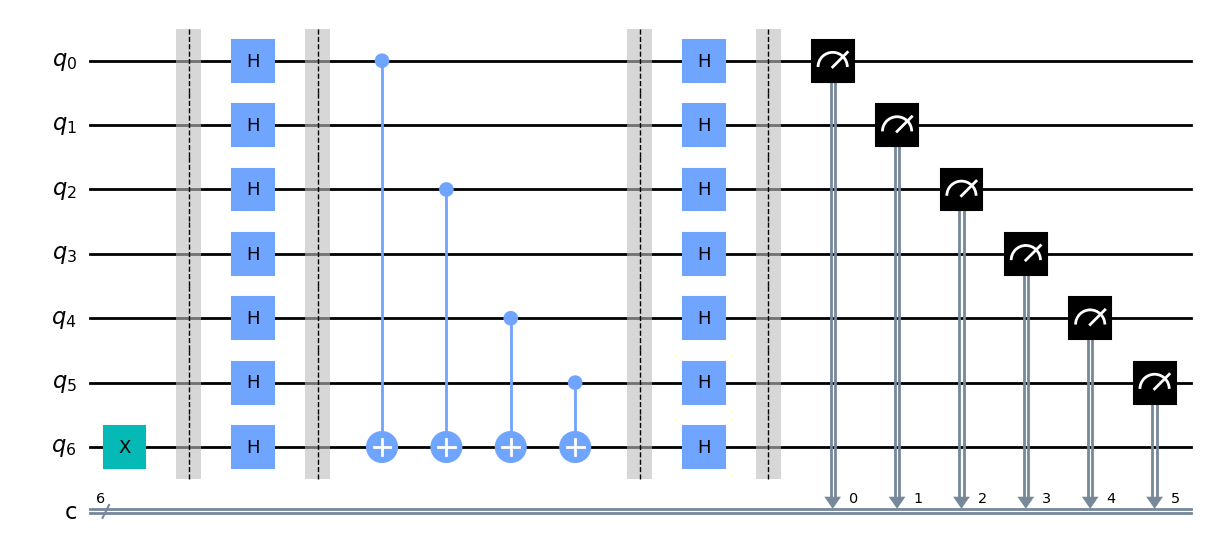

In [7]:
from qbraid.interface import circuit_drawer

circuit_drawer(qiskit_circuit, "mpl")  # Visualizing the circuit

## Running on an AWS Device via qBraid

Let's check which devices (specifically AWS ones) are online, and also find their device IDs:

In [8]:
from qbraid import get_devices

In [9]:
get_devices(filters={"runPackage": "braket"})

Provider,Name,qBraid ID,Status
AWS,DM1,aws_dm_sim,●
AWS,SV1,aws_sv_sim,●
AWS,TN1,aws_tn_sim,●
IonQ,Aria-1,aws_ionq_aria1,●
IonQ,Harmony,aws_ionq_harmony,●
OQC,Lucy,aws_oqc_lucy,○
QuEra,Aquila,aws_quera_aquila,○
Rigetti,Aspen-M-2,aws_rigetti_aspen_m2,○
Rigetti,Aspen-M-3,aws_rigetti_aspen_m3,●
Xanadu,Borealis,aws_xanadu_borealis,○


While we're at it, let's check how many credits we have left:

In [10]:
!qbraid jobs get-credits

You have 956.00 remaining qBraid credits.


In this tutorial we'll use Amazon's SV1 computer, since we see that it's online. Now we can use qBraid's [device wrapper](https://docs.qbraid.com/en/latest/sdk/devices.html#device-wrapper) to run a job on an Amazon device. The device wrapper adds a layer of abstraction, allowing us to run a qiskit circuit on an AWS quantum computer. Note that there's no need for any sort of circuit wrapper here – we can plug the qiskit circuit directly into the wrapped device!

In [11]:
from qbraid import device_wrapper

In [12]:
aws_device_id = "aws_sv_sim"  # aws_sv_sim is the qBraid id for the SV1 Computer
device = device_wrapper(aws_device_id)

In [13]:
braket_job = device.run(qiskit_circuit, shots=1000)
braket_job.status()  # checking the status of our job

<JobStatus.COMPLETED: 'job has successfully run'>

In [14]:
result = braket_job.result()
counts = result.measurement_counts()
print(counts)

{'1110101': 1000}


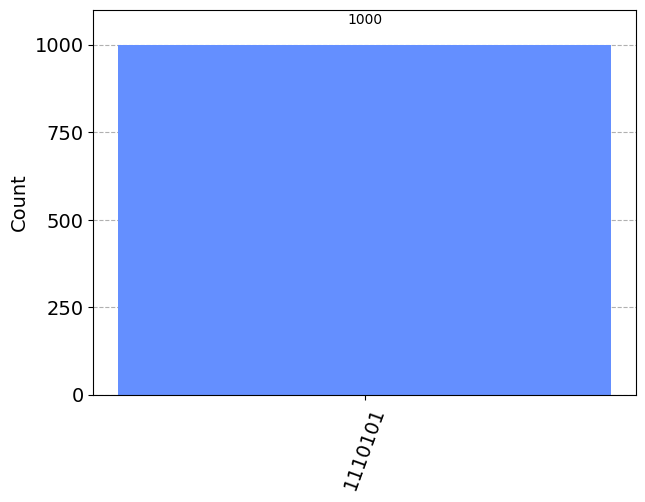

In [15]:
result.plot_counts()

We have guessed the number correctly! Note the bar graph where only one number was guessed in all 1000 shots

Finally we can estimate the cost of our job:

In [16]:
cost = braket_job.metadata()["cost"]
print(f"costEstimate: {cost} credits ~ ${cost/100}")

costEstimate: 0.40009555 credits ~ $0.0040009555
